In this notebook I want to Run 5 Fold Cross-Validation Grid Search of the Random Forest Model using multiple different metrics

In [56]:
import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

import ml_utils as mu

url='data/all_data_outliers_removed.xlsx'
classes = {1:1, 2:2}
use_v3 = True
resample = False

raw_data = pd.read_excel(url)

if raw_data.get('Subject').any():
    data = raw_data.drop('Subject', axis=1)

if classes:
    data = mu.group_classes(data, classes)

X, y = mu.split_x_and_y(data)
X, X_holdout, y, y_holdout = train_test_split(X, y, test_size = 0.2, random_state = 43, stratify=y)

holdout_data = X_holdout.copy()
holdout_data['GroupID'] = y_holdout

Xh, yh = mu.split_x_and_y(holdout_data)
if resample:
    Xh, yh = mu.resample_to_equal_class_sizes(Xh, yh)

validation_data = mu.get_validation_data(use_v3=True)
if classes:
    validation_data = mu.group_classes(validation_data, classes)
Xv, yv = mu.split_x_and_y(validation_data)
if resample:
    Xv, yv = mu.resample_to_equal_class_sizes(Xv, yv)

# y = y.replace(1,0)
y = y.replace(2,0)
# yh = pd.Series(yh).replace(1,0)
yh = pd.Series(yh).replace(2,0)
# yv = pd.Series(yv).replace(1,0)
yv = pd.Series(yv).replace(2,0)

Fitting 2 folds for each of 504 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed:   32.3s finished


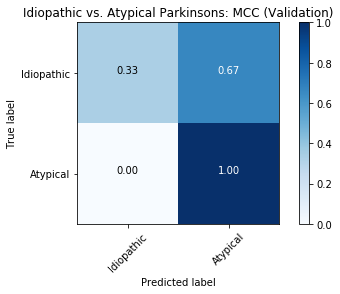

HOLDOUT ACCURACY: 0.918


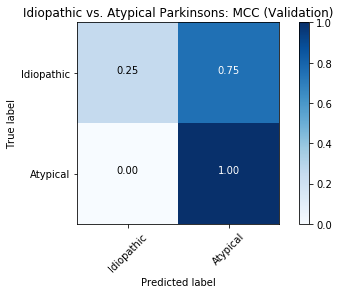

VALIDATION ACCURACY: 0.867



In [60]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

import pandas as pd

import ml_utils as mu

clf = Pipeline([
    ('standardization', StandardScaler()),
    ('oversampler', RandomOverSampler()),
    ('classifier', RandomForestClassifier())
])

scorings = {'MCC': metrics.make_scorer(metrics.matthews_corrcoef)}

for scoring in scorings.keys():
    gs = GridSearchCV(clf,
                      param_grid={
                "classifier__n_estimators": range(25,200, 25),
                #     "classifier__max_features": range(1, 38, 2),
                #     "classifier__max_depth": range(1, 21, 2),
                "classifier__min_samples_split": range(2, 20, 2),
                "classifier__min_samples_leaf": range(1, 25, 3),
            },
                      scoring=scorings[scoring], cv=2, n_jobs=-1, verbose=1)

    gs.fit(X, y)
    yh_pred = gs.predict(Xh)
    cnf_matrix=metrics.confusion_matrix(yh, yh_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, normalize=True,classes=['Idiopathic', 'Atypical'], title="Idiopathic vs. Atypical Parkinsons: %s (Validation)" %scoring)
    print("HOLDOUT ACCURACY: %.3f" %metrics.accuracy_score(yh,yh_pred))

    yv_pred = gs.predict(Xv)
    cnf_matrix=metrics.confusion_matrix(yv, yv_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, normalize=True,classes=['Idiopathic', 'Atypical'], title="Idiopathic vs. Atypical Parkinsons: %s (Validation)" %scoring)
    print("VALIDATION ACCURACY: %.3f" %metrics.accuracy_score(yv,yv_pred))
    print()